Improt libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


Data collection

In [3]:
df = pd.read_csv("../../data/raw/winequality-red.csv")
df.shape

(1599, 12)

In [4]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [5]:
#checking for null values
df.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

Data Analysis and Visulaization

1. Class distribution

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


/tmp/ipykernel_979/2313325544.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='quality', data=df, palette='viridis')


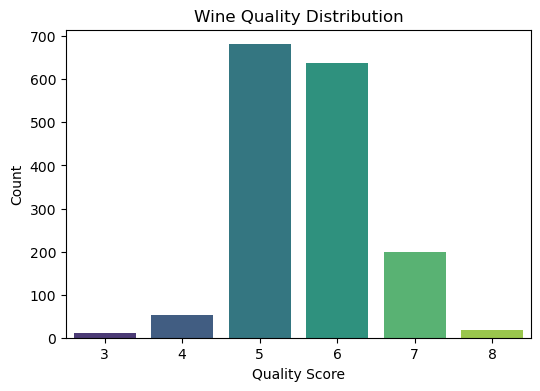

In [11]:
# Quick overview of data
df.info()
df.describe()

# Check class balance
plt.figure(figsize=(6,4))
sns.countplot(x='quality', data=df, palette='viridis')
plt.title('Wine Quality Distribution')
plt.xlabel('Quality Score')
plt.ylabel('Count')
plt.show()


2. Feature Distributions

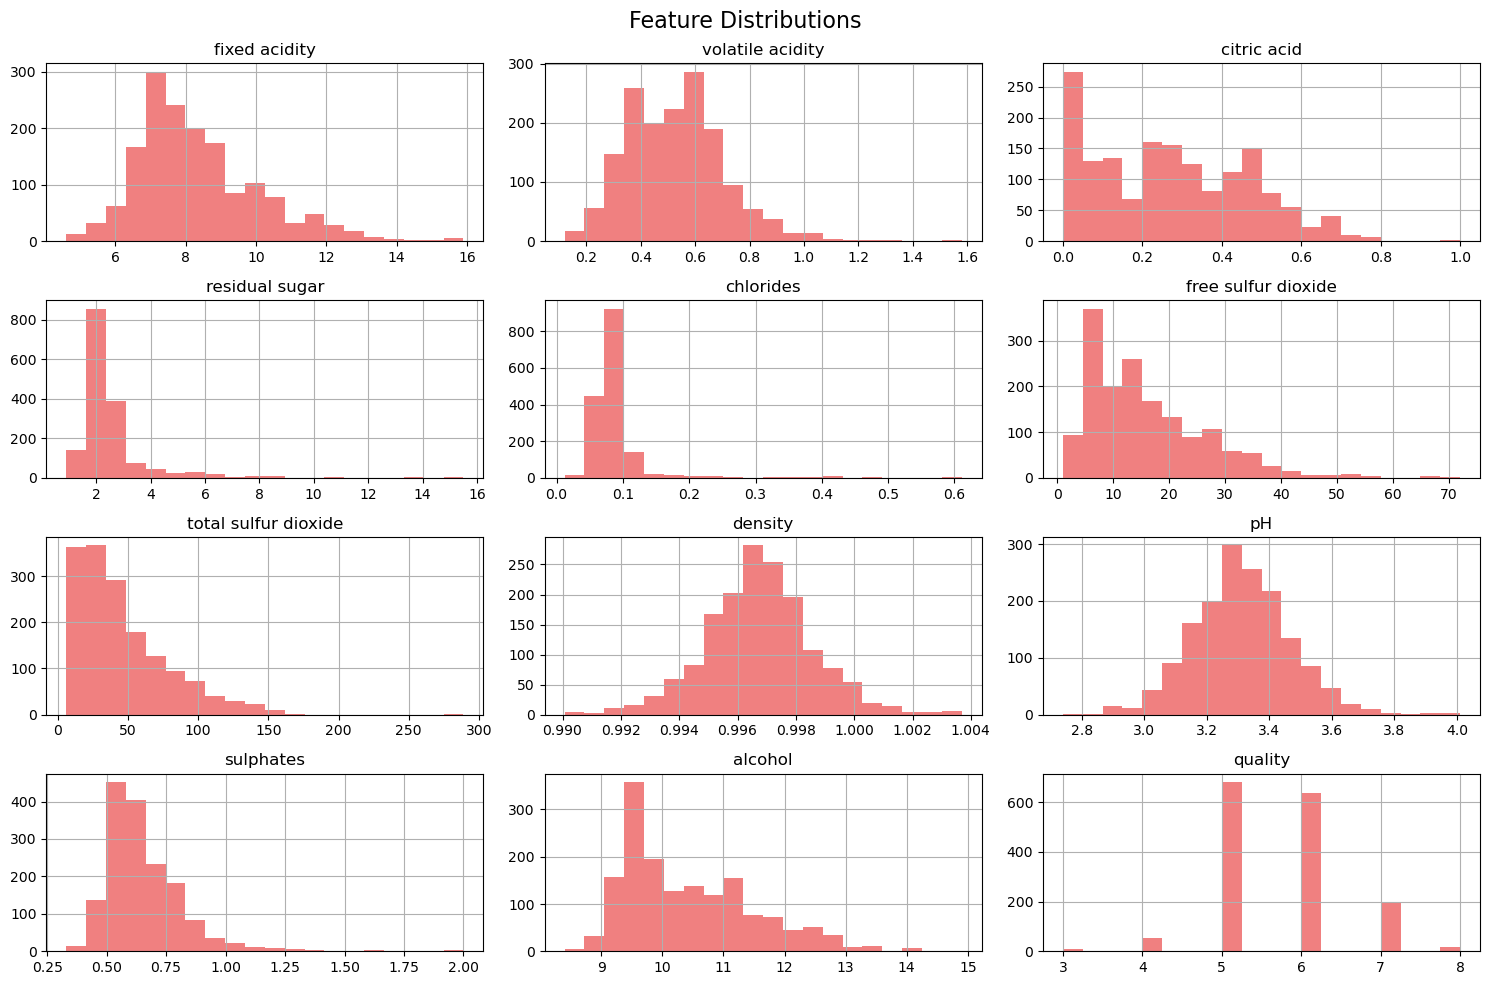

In [12]:
# Plot distributions for all features
df.hist(bins=20, figsize=(15,10), color='lightcoral')
plt.suptitle('Feature Distributions', fontsize=16)
plt.tight_layout()
plt.show()

3. Boxplots by Quality (Feature vs Target)

/tmp/ipykernel_979/1688166357.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='quality', y=col, data=df, palette='magma')
/tmp/ipykernel_979/1688166357.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='quality', y=col, data=df, palette='magma')
/tmp/ipykernel_979/1688166357.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='quality', y=col, data=df, palette='magma')
/tmp/ipykernel_979/1688166357.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variabl

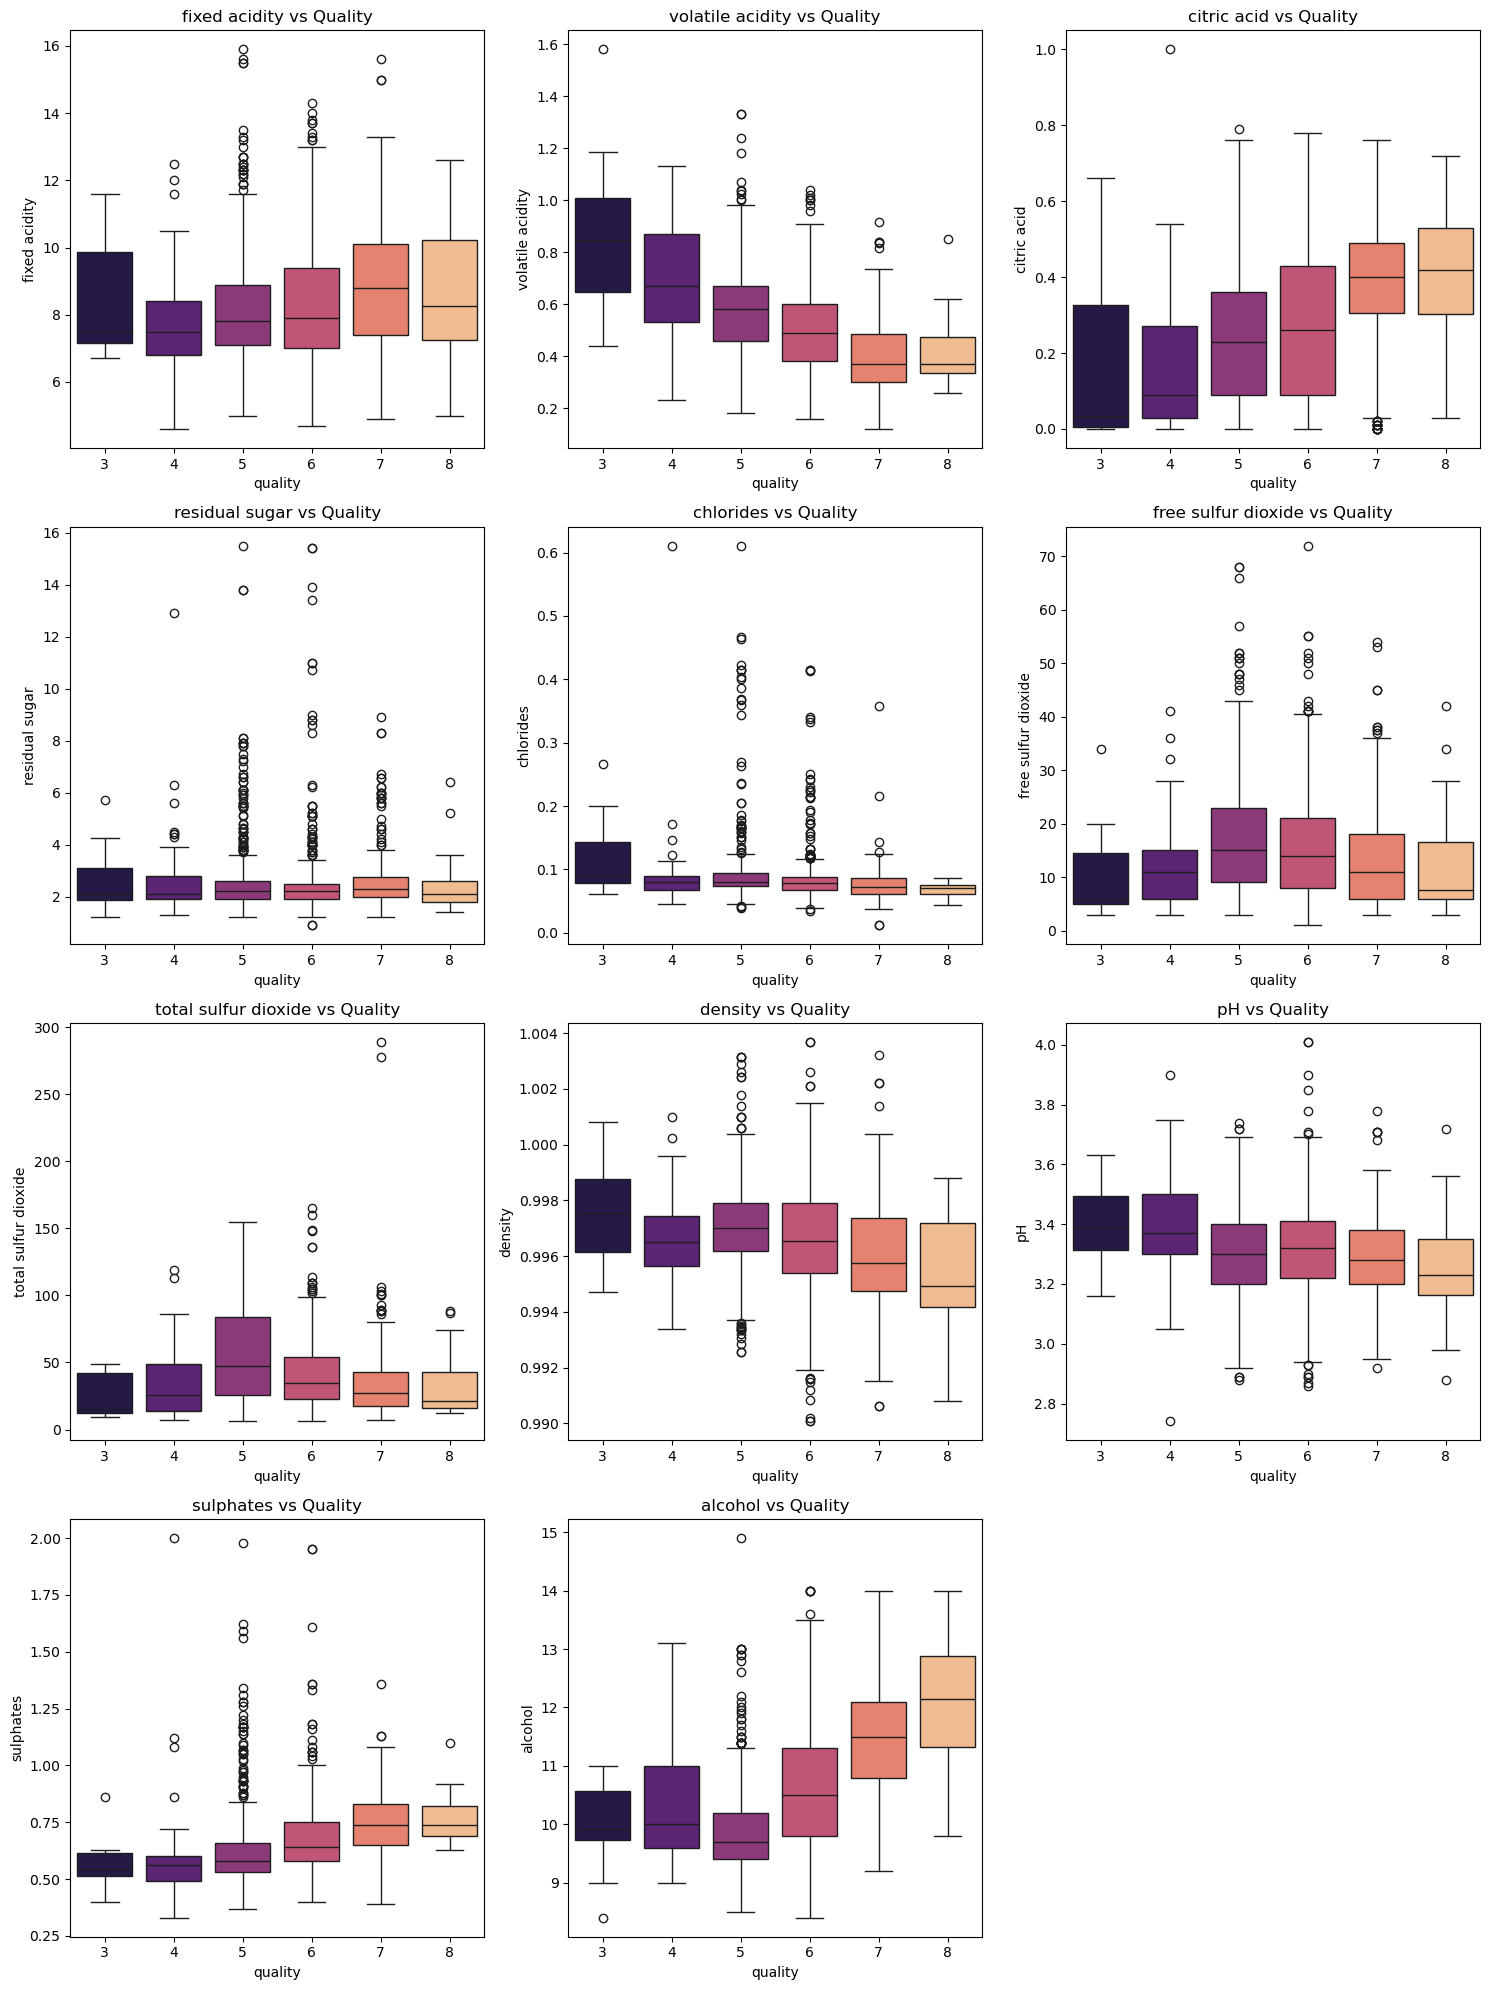

In [13]:
# Boxplot of each feature grouped by wine quality
features = df.columns[:-1]  # Exclude 'quality'

plt.figure(figsize=(15, 20))
for i, col in enumerate(features):
    plt.subplot(4, 3, i+1)
    sns.boxplot(x='quality', y=col, data=df, palette='magma')
    plt.title(f'{col} vs Quality')

plt.tight_layout()
plt.show()

<Axes: xlabel='quality', ylabel='volatile acidity'>

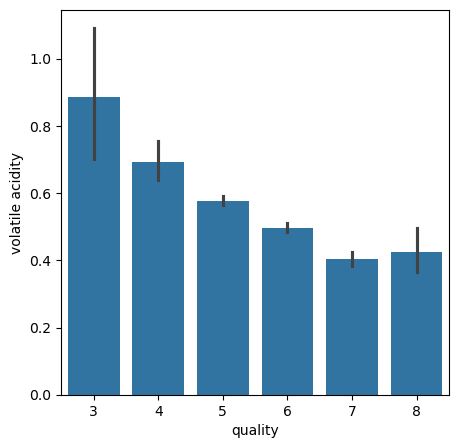

In [8]:
# volatile acidity vs Quality
plot = plt.figure(figsize=(5,5))
sns.barplot(x='quality', y = 'volatile acidity', data = df)

<Axes: xlabel='quality', ylabel='citric acid'>

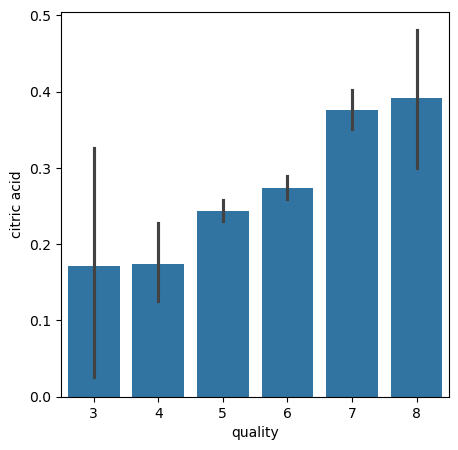

In [9]:
# citric acid vs Quality
plot = plt.figure(figsize=(5,5))
sns.barplot(x='quality', y = 'citric acid', data = df)